# Tutorial II: Custom Filters

The dpEmu package provides many filters for common use cases, but it might occur that no built-in filter exists for what you want. To solve this problem, you can create your own filters by inheriting the filter template. In this tutorial, we will create a custom filter for converting input images from RGB to grayscale.

First, let's generate some input data. We'll use numpy's randomstate with a set seed to ensure repeatability. The randomstate object simply replaces the np.random-part of any function call you want to make to numpy's random module.

In [34]:
import matplotlib.pyplot as plt
import numpy as np

rand = np.random.RandomState(seed=0)
img = rand.randint(low=0, high=255, size=(20, 20, 3))
data = np.array([img for _ in range(9)])

Let's see what these random images look like:

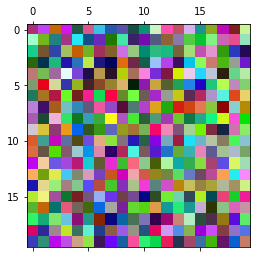

In [37]:
plt.matshow(data[0])

Before we write our own filter, let's rehearse what we learned in the previous tutorial and try modifying the image with an existing filter. We'll use the Resolution filter here.

In [38]:
from dpemu.nodes import Array, Series
from dpemu.filters.image import Resolution

image_node = Array()
series_node = Series(image_node)
resolution_filter = Resolution("scale")
image_node.addfilter(resolution_filter)

params = {"scale" : 2}
errorified = series_node.generate_error(data, params)

Let's quickly check that the output is what we'd expect:

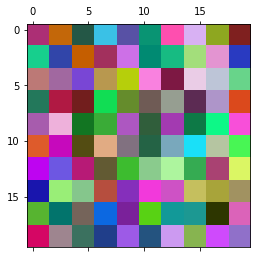

In [39]:
plt.matshow(errorified[0])

Now we're ready to write our own filter to replace the built-in resolution filter. To do this, we want to inherit the Filter-class in dpemu.filters.filter. The class has the functions "set_params" and "apply" that we have to override. In this case however, we do not need to do anything in "set_params", since our grayscale filter doesn't take parameters. Additionally, we do not need any of the parameters passed to "apply", which applies our filter to the data, other than the data itself. Later on in this tutorial you'll see examples of how these parameters can be used.

In [40]:
from dpemu.filters.filter import Filter

class Grayscale(Filter):
    def __init__(self):
        super().__init__()
    def set_params(self, params_dict):
        pass
    def apply(self, node_data, random_state, named_dims):
        avg = np.sum(node_data, axis=-1) // 3
        for ci in range(3):
            node_data[:, :, ci] = avg

Let's try it, overwriting the old variables:

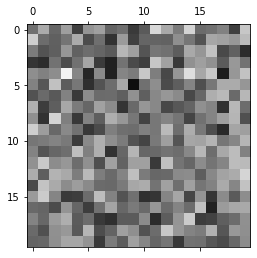

In [41]:
image_node = Array()
series_node = Series(image_node)
grayscale_filter = Grayscale()
image_node.addfilter(grayscale_filter)

params = {}
errorified = series_node.generate_error(data, params)

plt.matshow(errorified[0])

It works! The code here is very simple. In the apply-function, we just take the mean of the color channels, and then assign that to each of them. Since our filter doesn't take any parameters, we don't pass any when calling generate_error.

Note that Filters must always maintain the dimensions of the input data. Thay is why the processed image will still contain 3 color channels, despite being in grayscale.

Now that we understand how a simple filter works, let's modify it to incorporate randomness and parameters. We'll change it so that every pixel gets replaced with its grayscale equivalent with some probability given as a parameter:

In [48]:
class RandomGrayscale(Filter):
    def __init__(self, probability_id):
        super().__init__()
        self.probability_id = probability_id
    def set_params(self, params_dict):
        self.probability = params_dict[self.probability_id]
    def apply(self, node_data, random_state, named_dims):
        inds = random_state.rand(node_data.shape[0], node_data.shape[1]) < self.probability
        avg = np.sum(node_data[inds], axis=-1) // 3
        for ci in range(3):
            node_data[inds, ci] = avg

In function "__init__", we take the identifier for our probability parameter. This identifier will give the key for the value of probability in the params-dictionary given to generate_error. In set_params, we set the parameter by taking its value from the dictionary.

In apply, we randomize the positions where the pixel will be replaced by its grayscale equivalent, then replace them as we did previously. For repeatability, the function is passed a numpy RandomState, which can be used just like we did at the beginning of the tutorial.

Let's inspect the results:

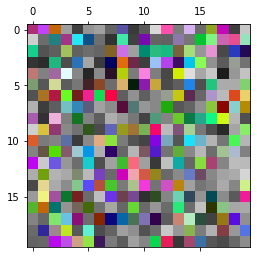

In [43]:
image_node = Array()
series_node = Series(image_node)
grayscale_filter = RandomGrayscale("probability")
image_node.addfilter(grayscale_filter)

params = {"probability" : 0.5}
errorified = series_node.generate_error(data, params)

plt.matshow(errorified[0])

Just as we wanted it! Now, the only thing we are yet to understand is the "named_dims" parameter to "apply". For this, imagine our tuple of ten images is a video. We'll create a filter that turns more and more of the pixels in the images into grayscale as time progresses. The filter doesn't require much change for this, most of the new code is just randomizing the times at which individual pixels decay at given the halftime. Note that we make a copy of the random_state to ensure that we generate the same times for every image in the series.

In [47]:
from math import log
from copy import deepcopy

class DecayGrayscale(Filter):
    def __init__(self, half_time_id):
        super().__init__()
        self.half_time_id = half_time_id
    def set_params(self, params_dict):
        self.half_time = params_dict[self.half_time_id]
    def apply(self, node_data, random_state, named_dims):
        shape = (node_data.shape[0], node_data.shape[1])
        times = deepcopy(random_state).exponential(scale=(self.half_time / log(2)), size=shape)
        inds = times <= named_dims["time"] # Which positions turn grayscale at or before the current time
        avg = np.sum(node_data[inds], axis=-1) // 3
        for ci in range(3):
            node_data[inds, ci] = avg

To use this filter, we'll have to tell the series-node that the dimension it is iterating over is called "time":

In [45]:
image_node = Array()
series_node = Series(image_node, "time")
grayscale_filter = DecayGrayscale("half_time")
image_node.addfilter(grayscale_filter)

params = {"half_time" : 1}
errorified = series_node.generate_error(data, params)

To show multiple images in the same plot, we'll have to do some more work:

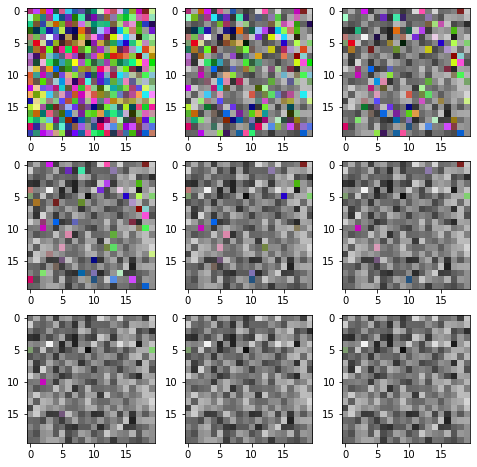

In [46]:
fig = plt.figure(figsize=(8, 8))
for i in range(1, 9 + 1):
    fig.add_subplot(3, 3, i)
    plt.imshow(errorified[i-1])
plt.show()

And we have achieved the desired effect! This concludes the second tutorial. Hopefully you now understand how to use DPemu to generate errors, and how to create your own filters for the error generation tree.

The notebook for this tutorial can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/tutorials/Custom_Filters.ipynb).